In [1]:
#%%  Load the packages
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [2]:
#%% read the data

# Read the IMD and city boundary
imd = gpd.read_file("data/UF_DOE/data/IMD/IMD.shp")
city_boundary = gpd.read_file("data/UF_DOE/data/Chicago_Cityboundary/cityboundary.shp")
rail_stations = gpd.read_file("data/UF_DOE/data/CTA_RailStations_2024/CTA_RailStations.shp")

# Read the transit stops and routes
stops = pd.read_csv("data/UF_DOE/data/CTA_BusStops_2024/stops.txt")
geometry = [Point(xy) for xy in zip(stops["stop_lon"], stops["stop_lat"])]
stops = gpd.GeoDataFrame(stops, geometry=geometry)
stops.set_index("stop_id", inplace=True)
stops.set_crs(epsg=4326, inplace=True)
stops = stops.to_crs(imd.crs)

imd_stops = pd.read_csv("data/UF_DOE/data/transit_od_APC/ODX/imd_route_stops.csv")
bus_routes = gpd.read_file("data/UF_DOE/data/CTA_Bus Routes_2024/bus_routes.shp")
bus_routes = bus_routes.to_crs(imd.crs)
imd_bus_routes = bus_routes.loc[bus_routes.route.isin(imd_stops.route_id.unique()), :]
rail_routes = gpd.read_file("data/UF_DOE/data/CTA_RailLines_2024/Rail_route.shp")
rail_routes = rail_routes.to_crs(imd.crs)


IMD_stops = (44, 48, 99, 100, 101, 103, 107, 108, 188, 189, 190, 191, 193, 216, 217,
	218, 296, 297, 298, 341, 342, 343, 344, 348, 6043, 6046, 6049, 6227, 6228, 6230, 6233, 6636, 6637, 6638,
	6639, 6640, 6642, 6643, 6644, 6681, 6683, 6684, 6685, 6686, 6689, 6690, 6691, 6692, 6693, 8239, 8245, 8368, 8371, 8373, 8872, 8873, 8874,
	8875, 8876, 8878, 8880, 8881, 8882, 8898, 8899, 8900, 8901, 8902, 8904, 8905, 8906, 8907, 13191, 13192, 14203, 14204, 14205, 14206, 14207, 14554,
	14769, 15345, 15414, 15415, 15785, 15793, 15869, 15983, 17061, 17063, 17067, 17074, 17075, 17117, 17183, 17226, 17312, 17890, 18129, 18130, 18301,
	18334, 18395, 18428, 18486, 30157, 30158, 30199, 30200, 999034, 999035)

dataframe_imd_stops = pd.DataFrame(IMD_stops, columns=["SYSTEMSTOP"])

In [3]:
#%% Read odx data, and drop duplicates or nan values

odx = pd.read_csv(
    "data/UF_DOE/data/transit_od_APC/ODX/DOE_ODX_with_transfers_202412102222.csv",
    parse_dates=["transaction_dtm", "alighting_time"],
)
print(f"Total {odx.shape[0]} trips in the ODX data")
odx = odx.drop_duplicates()
print(f"Total {odx.shape[0]} trips after dropping duplicates")

# Drop rows with unrecognized stops
print(f"Total {odx.boarding_stop.nunique()} unique boarding stops, found {odx.boarding_stop[odx.boarding_stop.isin(stops.index)].nunique()} boarding stops in the CTA bus stops data")
print(f"Total {odx.inferred_alighting_gtfs_stop.nunique()} unique alighting stops, found {odx.inferred_alighting_gtfs_stop[odx.inferred_alighting_gtfs_stop.isin(stops.index)].nunique()} alighting stops in the CTA bus stops data")

odx.loc[((~odx.boarding_stop.isin(stops.index))|
         odx.boarding_stop.isna()), 'boarding_stop'] = np.nan

odx.loc[((~odx.inferred_alighting_gtfs_stop.isin(stops.index))|
         odx.inferred_alighting_gtfs_stop.isna()), :] = np.nan

# Drop rows with both unrecognized boarding and alighting stops
odx = odx.loc[~(odx.boarding_stop.isna() & odx.inferred_alighting_gtfs_stop.isna()), :]
print(f"Total {odx.shape[0]} trips after dropping unrecognized stops")

Total 506939 trips in the ODX data
Total 320591 trips after dropping duplicates
Total 4219 unique boarding stops, found 4202 boarding stops in the CTA bus stops data
Total 4029 unique alighting stops, found 4020 alighting stops in the CTA bus stops data
Total 252672 trips after dropping unrecognized stops


np.int64(19)

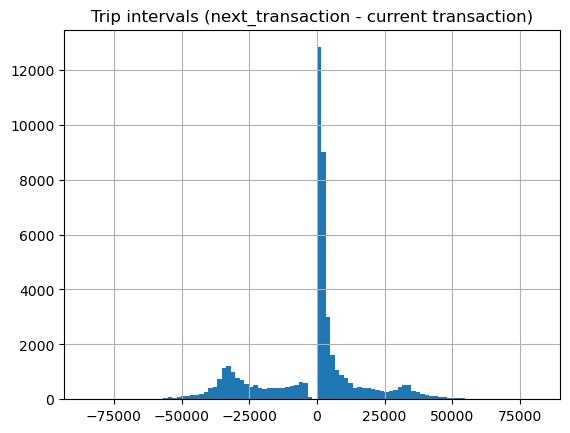

In [4]:
#%% Examine trips that start from IMD

odx_s = odx.loc[odx.boarding_stop.isin(IMD_stops), :]
odx_s2 = odx.loc[(odx.dw_transaction_id.isin(odx_s.next_transaction)), :]  # The next trip
data_s = pd.merge(odx_s, odx_s2,
                left_on="next_transaction",
                right_on="dw_transaction_id",
                suffixes=("_trip1", "_trip2"))
interval_seconds = (
    (data_s.transaction_dtm_trip2 - data_s.transaction_dtm_trip1)
    .astype('timedelta64[s]')
    .astype('int')
    )
interval_seconds.hist(bins=100)
plt.title("Trip intervals (next_transaction - current transaction)")

(data_s.dw_transaction_id_trip1 == data_s.last_transaction_in_journey_trip2).sum()

np.int64(29)

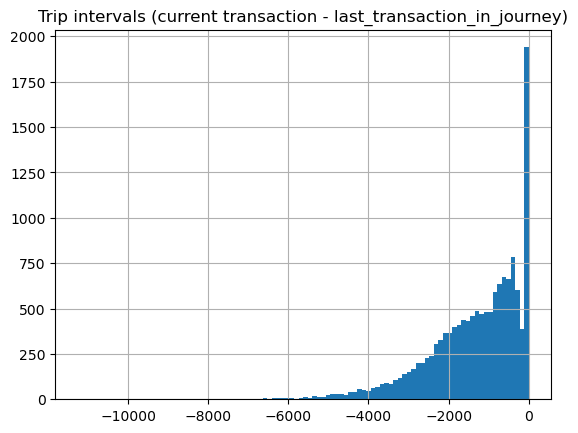

In [5]:
#%% Examine trips that end at IMD

odx_e = odx.loc[odx.inferred_alighting_gtfs_stop.isin(IMD_stops), :]
odx_e0 = odx.loc[
    odx.dw_transaction_id.isin(
        odx_e.loc[odx_e.last_transaction_in_journey!=odx_e.dw_transaction_id, 'last_transaction_in_journey']
        ),
    :]
data_e = pd.merge(odx_e0, odx_e,
                left_on="dw_transaction_id",
                right_on="last_transaction_in_journey",
                suffixes=("_trip1", "_trip2"))
interval_seconds = (
    (data_e.transaction_dtm_trip2 - data_e.transaction_dtm_trip1)
    .astype('timedelta64[s]')
    .astype('int')
    )

interval_seconds.hist(bins=100)
plt.title("Trip intervals (current transaction - last_transaction_in_journey)")

(data_e.next_transaction_trip1 == data_e.dw_transaction_id_trip2).sum()

## Select a trip chain for visualization

In [6]:
#%% Examine trips with visualizations

def plot_trips(data, line):
    boarding_trip1 = data.at[line, "boarding_stop_trip1"]
    alighting_trip1 = data.at[line, "inferred_alighting_gtfs_stop_trip1"]
    time_trip1 = data.at[line, "transaction_dtm_trip1"]

    boarding_trip2 = data.at[line, "boarding_stop_trip2"]
    alighting_trip2 = data.at[line, "inferred_alighting_gtfs_stop_trip2"]
    time_trip2 = data.at[line, "transaction_dtm_trip2"]

    fig, ax = plt.subplots(figsize=(5, 8))
    imd.plot(ax=ax, color="black", edgecolor="none", zorder=1, alpha=0.5)
    city_boundary.plot(ax=ax, color="none", edgecolor="black", zorder=5)
    colors = ["red", "blue"]
    from matplotlib.patches import FancyArrowPatch
    for i, trip in enumerate([[boarding_trip1, alighting_trip1],[boarding_trip2, alighting_trip2]]):
        if np.isnan(trip[0]) or np.isnan(trip[1]):
            for stop in trip:
                if ~np.isnan(stop):
                    stop = int(stop)
                    stops.loc[[stop], :].plot(ax=ax, color=colors[i], zorder=10, markersize=5)
        else:
            arrow = FancyArrowPatch(
                (stops.loc[trip[0], "geometry"].x, stops.loc[trip[0], "geometry"].y),
                (stops.loc[trip[1], "geometry"].x, stops.loc[trip[1], "geometry"].y),
                color=colors[i],
                zorder=10,
                mutation_scale=10,
                arrowstyle="->",
            )
            plt.gca().add_patch(arrow)
    ax.text(
    0.05, 0.05,
    f"Trip 1: {time_trip1}\n",
    transform=ax.transAxes,
    color=colors[0],
    )

    ax.text(
    0.05, 0.01,
    f"Trip 2: {time_trip2}\n",
    transform=ax.transAxes,
    color=colors[1],
    )

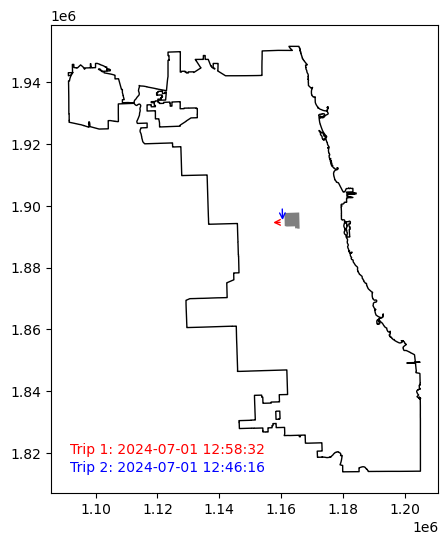

In [7]:
# Visulize trips end in IMD (last_transaction_in_journey, current transaction)
plot_trips(data_e, 102)

In [8]:
#%% Filter out all error data, and examine the trips
data_s = pd.merge(odx_s, odx_s2,
                left_on="next_transaction",
                right_on="dw_transaction_id",
                suffixes=("_trip1", "_trip2"),
                how="outer")

data_s['interval_seconds'] = (
    (data_s.transaction_dtm_trip2 - data_s.transaction_dtm_trip1)
    .astype('timedelta64[s]')
    .astype('int')
    )

data_s.interval_seconds = data_s.interval_seconds.astype('float')
data_s.loc[data_s.dw_transaction_id_trip2.isna(), 'interval_seconds'] = np.nan
data_s = data_s.loc[((data_s.interval_seconds>60)|
                     (data_s.dw_transaction_id_trip2.isna())), :]
data_s = data_s.loc[((data_s.interval_seconds<=60*60)|
                     (data_s.dw_transaction_id_trip2.isna())), :]
data_s = data_s.reset_index(drop=True)

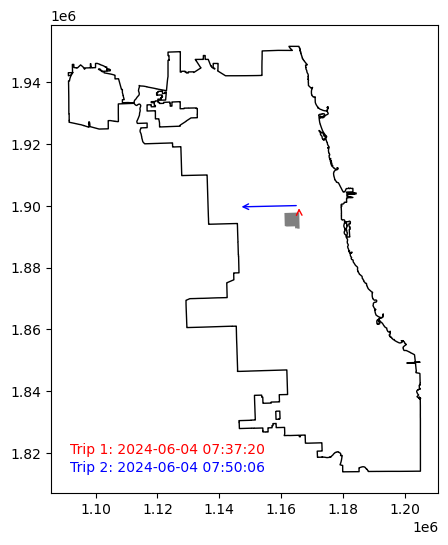

In [9]:
# Visulize trips start at IMD (current transaction, next_transaction)
plot_trips(data_s, 101)

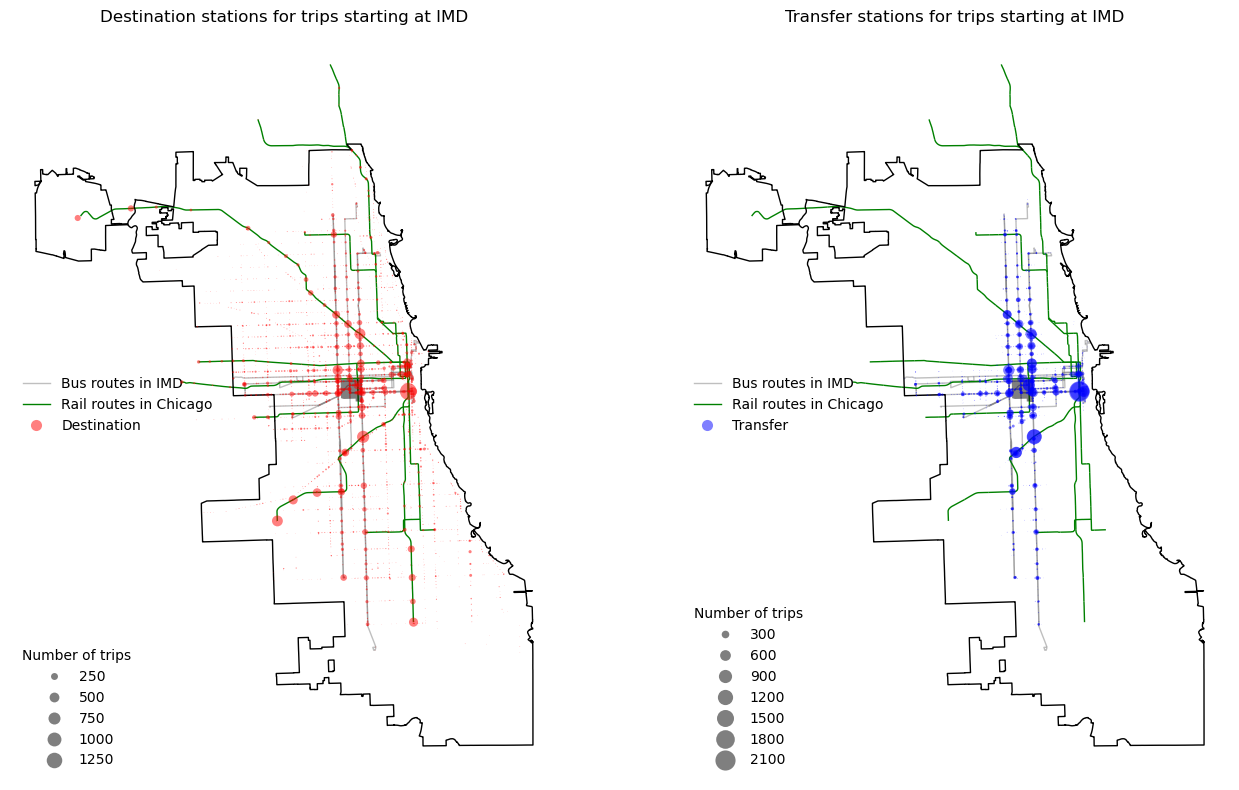

In [10]:
alightings = np.concatenate([data_s.loc[data_s.dw_transaction_id_trip2.isna(),
                                        'inferred_alighting_gtfs_stop_trip1'].
                             dropna().values,
                             data_s.inferred_alighting_gtfs_stop_trip2.dropna().values])
alightings_value_counts = pd.Series(alightings).value_counts()

transfers = data_s.loc[~data_s.dw_transaction_id_trip2.isna(),
                       ['boarding_stop_trip2', 'inferred_alighting_gtfs_stop_trip1']]
transfers.loc[transfers.boarding_stop_trip2 == transfers.inferred_alighting_gtfs_stop_trip1, 'boarding_stop_trip2'] = np.nan
transfers = transfers.dropna().values.flatten()
transfers_value_counts = pd.Series(transfers).value_counts()
boardings_value_counts = data_s.boarding_stop_trip1.dropna().value_counts()


from matplotlib.lines import Line2D
fig, axes = plt.subplots(1, 2, figsize=(14, 8))
demand_counts = [alightings_value_counts, transfers_value_counts]
colors = ['red', 'blue']
labels = ['Destination', 'Transfer']
for i, ax in enumerate(axes):
    imd.plot(ax=ax, color="black", edgecolor="none", zorder=1, alpha=0.5)
    city_boundary.plot(ax=ax, color="none", edgecolor="black", zorder=5)
    imd_bus_routes.plot(ax=ax, color="gray", edgecolor="gray", alpha=0.5, lw=1, zorder=0,
                        label='Bus routes through IMD')
    rail_routes.plot(ax=ax, color="green", edgecolor="green", alpha=1, lw=1, zorder=0)

    # Plot the alightings
    sc = ax.scatter(
        stops.loc[demand_counts[i].index, "geometry"].x,
        stops.loc[demand_counts[i].index, "geometry"].y,
        s=demand_counts[i].values/10, color=colors[i], zorder=10, alpha=0.5,
        edgecolor="none", linewidth=0, label=labels[i],
    )


    ax.set_title(f"{labels[i]} stations for trips starting at IMD")
    ax.axis('off')

    # Create custom legend elements for color categories
    legend_elements = [
        Line2D([0], [0], color='gray', lw=1, label='Bus routes in IMD', alpha=0.5),
        Line2D([0], [0], color='green', lw=1, label='Rail routes in Chicago', alpha=1),
        Line2D([0], [0], marker='o', color=colors[i], label=labels[i],
            linestyle='None', markersize=8, alpha=0.5, markeredgecolor='none'),
    ]

    # Add color legend
    color_legend = ax.legend(handles=legend_elements, loc='center left', frameon=False)

    # Create and adjust size legend
    size_handles, size_labels = sc.legend_elements("sizes", num=6)
    size_labels = [
        str(int(float(label[14:].split(r'}$')[0]) * 10))
        for label in size_labels
    ]
    size_legend = ax.legend(
        size_handles, size_labels, title="Number of trips", loc="lower left", frameon=False
    )
    # Add both legends to the plot
    ax.add_artist(color_legend)
fig.tight_layout()